In [6]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


## Saliency
saliency maps tells us what parts of the image the model is focusing on when making its predictions. 


In [7]:
# Import
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import numpy as np
import matplotlib.pyplot as plt


## Build the model

For the classifier, we use the [Inception V3 model](https://arxiv.org/abs/1512.00567) available in [Tensorflow Hub](https://tfhub.dev/google/tf2-preview/inception_v3/classification/4). This has pre-trained weights that is able to detect 1001 classes. You can read more [here](https://tfhub.dev/google/tf2-preview/inception_v3/classification/4)

In [8]:
#model
model = tf.keras.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/tf2-preview/inception_v3/classification/4'),
    tf.keras.layers.Activation('softmax')
])

# build the model based on a specified batch input shape
model.build([None, 300, 300, 3])

In [13]:
#load and edit the image
img = cv2.imread('luke.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
img = cv2.resize(img, (300, 300)) / 255.0
# add a batch dimension in front
image = np.expand_dims(img, axis=0)

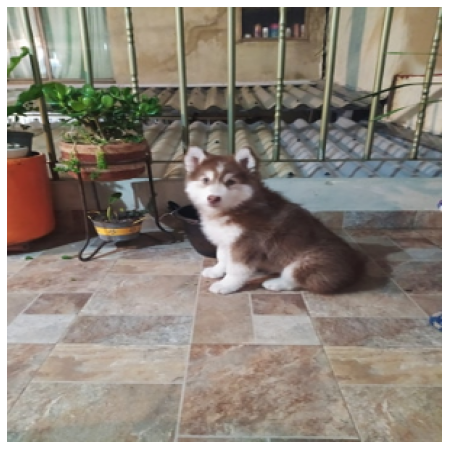

In [14]:
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

In [16]:
# Siberian Husky's class ID in ImageNet
class_index = 251   

# number of classes in the model's training data
num_classes = 1001

# convert to one hot representation to match our softmax activation in the model definition
expected_output = tf.one_hot([class_index] * image.shape[0], num_classes)

with tf.GradientTape() as tape:
    # cast image to float
    inputs = tf.cast(image, tf.float32)

    # watch the input pixels
    tape.watch(inputs)

    # generate the predictions
    predictions = model(inputs)

    # get the loss
    loss = tf.keras.losses.categorical_crossentropy(
        expected_output, predictions
    )

# get the gradient with respect to the inputs
gradients = tape.gradient(loss, inputs)

In [17]:
grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1)

# normalize the pixel values to be in the range [0, 255].

normalized_tensor = tf.cast(
    255
    * (grayscale_tensor - tf.reduce_min(grayscale_tensor))
    / (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),
    tf.uint8,
)

# remove the channel dimension to make the tensor a 2d tensor
normalized_tensor = tf.squeeze(normalized_tensor)

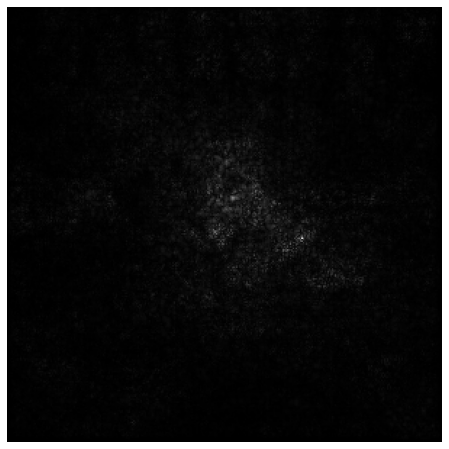

In [21]:
# The white pixels show the parts the model focused on when classifying the image.
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(normalized_tensor, cmap='gray')
plt.show()

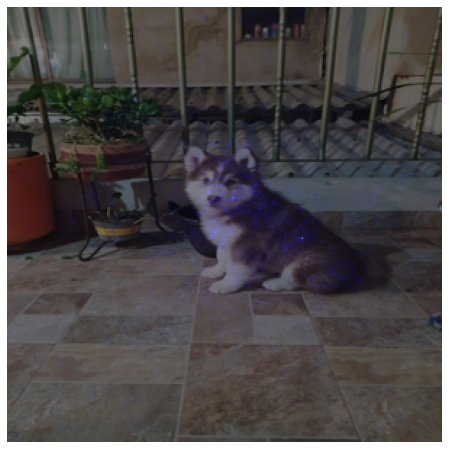

In [22]:
# Let's superimpose the normalized tensor to the input image to get more context
gradient_color = cv2.applyColorMap(normalized_tensor.numpy(), cv2.COLORMAP_HOT)
gradient_color = gradient_color / 255.0
super_imposed = cv2.addWeighted(img, 0.5, gradient_color, 0.5, 0.0)

plt.figure(figsize=(8, 8))
plt.imshow(super_imposed)
plt.axis('off')
plt.show()